## Predicting Airline Delays<br>

Notebook: Data Modeling
  
Team: Jimmy Nguyen, Maha Jayapal, Roberto Cancel<br>

## Packages 

In [1]:
#!pip install --upgrade numpy #ensure numpy and pandas are upgraded to same versions for easier exploration (avoiding errors)
#!pip install --upgrade pandas #ensure numpy and pandas are upgraded to same versions for easier exploration (avoiding errors)
#!pip install xgboost

import tarfile
import pickle as pkl
import boto3
import sagemaker
from sagemaker import image_uris
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
import io # for encoding issues with raw data sets
from io import StringIO # converting dataframe to csv and uploading to s3 bucket /tranformed folder

import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
import pickle as pkl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

## Set-up 

In [2]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [3]:
print("Default bucket: {}".format(bucket))

Default bucket: sagemaker-us-east-1-794305947067


## Train, Validation, and Test Data 

In [4]:
s3_client = boto3.resource('s3')

# training data
BUCKET = 'ads-508-airline'
KEY = "model_data/df_train.csv"

response = s3_client.Object(BUCKET, KEY)
train = pd.read_csv(response.get()['Body'])
train.head()

,DEP_DEL15,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND,WEEK_OF_MONTH
0,0.0,2,2,3,5175,1407,4076,2145,0.00,0.0,0.0,61.0,7.16,4
1,1.0,5,4,5,8989,9668,15475,2482,0.00,0.0,0.0,54.0,8.95,4
2,1.0,2,3,2,8989,9668,15475,2482,0.14,0.0,0.0,41.0,6.71,3
3,0.0,3,3,2,2444,23,2273,787,0.03,0.0,0.0,35.0,10.96,1
4,1.0,7,3,3,9293,15331,15809,6122,0.11,0.1,0.0,41.0,10.07,1


In [5]:
# validation data
KEY = "model_data/df_val.csv"

response = s3_client.Object(BUCKET, KEY)
valid = pd.read_csv(response.get()['Body'])
valid.head()

,DEP_DEL15,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND,WEEK_OF_MONTH
0,0.0,5,2,3,9293,15331,15809,6122,0.00,0.0,0.0,81.0,8.28,1
1,0.0,1,2,4,2893,1062,5737,898,0.00,0.0,0.0,47.0,4.03,2
2,0.0,5,3,3,8586,8586,15502,9677,0.00,0.0,0.0,31.0,11.86,3
3,0.0,5,3,10,9293,15331,15809,6122,0.01,0.0,0.0,52.0,11.41,4
4,0.0,7,2,5,2444,23,2273,787,0.00,0.0,0.0,79.0,14.54,4


In [6]:
# Test data
KEY = "model_data/df_test.csv"

response = s3_client.Object(BUCKET, KEY)
test = pd.read_csv(response.get()['Body'])
test.head()

,DEP_DEL15,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND,WEEK_OF_MONTH
0,1.0,6,4,2,9293,15331,15809,6122,0.01,0.0,0.0,55.0,9.40,2
1,0.0,1,3,11,586,893,1466,419,0.00,0.0,0.0,64.0,5.82,5
2,1.0,6,4,3,7637,16888,15237,4991,1.50,0.0,0.0,58.0,11.41,4
3,0.0,2,2,4,2840,4905,3888,726,0.00,0.0,0.0,55.0,14.09,3
4,0.0,2,3,6,7637,16888,15237,4991,0.00,0.0,0.0,84.0,12.08,5


## S3 Data Inputs for Modeling 

In [7]:
# Training data
KEY = "model_data/df_train.csv"
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}'.format(BUCKET, KEY), content_type='csv')


In [8]:
# Validation data
KEY = "model_data/df_val.csv"
s3_input_valid = sagemaker.TrainingInput(s3_data='s3://{}/{}'.format(BUCKET,KEY), content_type='csv')

In [9]:
# Test data
KEY = "model_data/df_test.csv"
s3_input_valid = sagemaker.TrainingInput(s3_data='s3://{}/{}'.format(BUCKET, KEY), content_type='csv')

## Modeling - XGBOOST

In [10]:
# initialize hyperparameters
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"binary:logistic",
        "num_round":"50", "eval_metric":"auc"}

# set an output path where the trained model will be saved
bucket = sagemaker.Session().default_bucket()
prefix = 'baseline_model'
output_path = 's3://{}/{}/{}/output'.format(bucket, prefix, 'xgb-built-in-algo')

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.2-2")

# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.large', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)

# define the data type and paths to the training and validation datasets
content_type = "libsvm"

# execute the XGBoost training job
estimator.fit({'train': s3_input_train, 'validation': s3_input_valid})

2022-03-30 17:27:46 Starting - Starting the training job...
2022-03-30 17:28:11 Starting - Preparing the instances for trainingProfilerReport-1648661266: InProgress
............
2022-03-30 17:29:58 Downloading - Downloading input data...
2022-03-30 17:30:44 Training - Downloading the training image........[2022-03-30 17:31:53.592 ip-10-0-139-118.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-03-30:17:31:53:INFO] Imported framework sagemaker_xgboost_container.training
[2022-03-30:17:31:53:INFO] Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
[2022-03-30:17:31:53:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2022-03-30:17:31:53:INFO] No GPUs detected (normal if no gpus installed)
[2022-03-30:17:31:53:INFO] Running XGBoost Sagemaker in algorithm mode
[2022-03-30:17:31:53:INFO] Determined delimiter of CSV input is ','
[2022-03-30:17:31:53:INFO] Determined delimit

## Evaluation 

In [17]:

# download the model artifact from AWS S3
!aws s3 cp s3://sagemaker-us-east-1-794305947067/baseline_model/xgb-built-in-algo/output/sagemaker-xgboost-2022-03-30-17-27-46-760/output/model.tar.gz .
    
#opens the downloaded model artifcat and loads it as 'model' variable
tar = tarfile.open('model.tar.gz')
tar.extractall()
tar.close()
model = pkl.load(open('xgboost-model', 'rb'))

download: s3://sagemaker-us-east-1-794305947067/baseline_model/xgb-built-in-algo/output/sagemaker-xgboost-2022-03-30-17-27-46-760/output/model.tar.gz to ./model.tar.gz


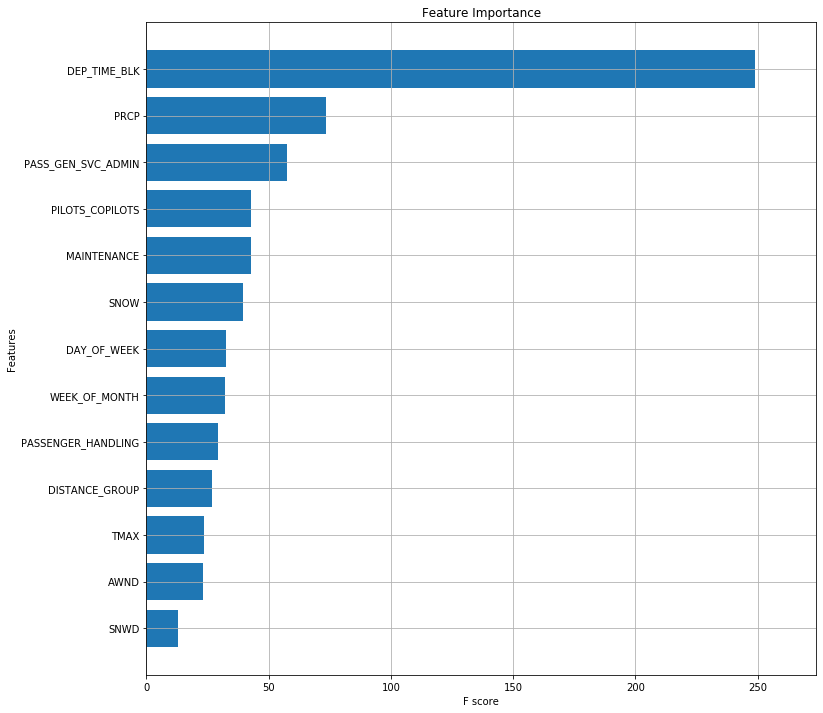

In [18]:
cols_input = ['DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
       'PILOTS_COPILOTS', 'PASSENGER_HANDLING', 'PASS_GEN_SVC_ADMIN',
       'MAINTENANCE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND', 'WEEK_OF_MONTH']

# Match up with feature names 
map_names = dict(zip(list(model.get_fscore().keys()), train[cols_input].columns))
model.feature_names = list(map_names.values())

#plot feature importance
fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(model, importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values = False)
plt.title('Feature Importance')
plt.show()